# **Please note you need a GPU with at least 24GB memory to test this 3D turbulence generation**

# Imports

In [2]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import torch
import numpy as np
from functools import partial
import sys
sys.path.append("../../../..")
from ConditionalDiffusionGeneration.src.guided_diffusion.unet import create_model
from ConditionalDiffusionGeneration.src.guided_diffusion.condition_methods import get_conditioning_method
from ConditionalDiffusionGeneration.src.guided_diffusion.measurements import get_noise, get_operator
from ConditionalDiffusionGeneration.src.guided_diffusion.gaussian_diffusion import create_sampler
from ConditionalNeuralField.cnf.inference_function import ReconstructFrame, decoder
from einops import rearrange

In [4]:
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"

device = torch.device(dev)
print(device)

cpu


In [5]:
torch.manual_seed(42)
np.random.seed(42)

# Conditioning Data Loader

In [6]:
no_of_sensors = 10 #1,10,100,1000

In [7]:
true_measurement = torch.from_numpy(np.load(f'input/random_sensor/{no_of_sensors}/measures.npy')).to(device)
print(f"True measurement shape: {true_measurement.shape} and value at 0,0: {true_measurement[0,0]}")

True measurement shape: torch.Size([384, 10, 3]) and value at 0,0: tensor([ 0.4638, -0.0730, -0.0079], dtype=torch.float64)


In [8]:
true_measurement.shape

torch.Size([384, 10, 3])

# Load trained unconditional model

# Operator and Noise

In [9]:
noiser = get_noise(sigma=0.0, name='gaussian')

## For masking in time

In [10]:
# start, stop, step = 0, 257, 5
mask = torch.ones_like(true_measurement, device=device)
# mask[start:stop:step] = 1

# Conditioning Method

# Sampler

## Generate Samples

In [11]:
no_of_samples = 10
time_length = 384
latent_size = 384

In [12]:
# Load gen_fields
import torch
gen_fields = torch.load(f"/Users/minghan/Desktop/output_files_sensor10/gen_fields.pt", map_location=device)  # Ensure it's loaded to the correct device

/var/folders/bc/tkxqx5c57fgcftsfpjb5zk8c0000gn/T/ipykernel_1243/1432118485.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_fields = torch.load(f"/Users/minghan/Deskt

# Decoding latents to flow fields

In [13]:
info = np.load("input/cnf_model/infos.npz")
coords = torch.tensor(np.load("input/cnf_model/coords.npy"), device=device, dtype=torch.float32)

# Post processing the flow fields for visualization

In [14]:
pred_data_list = []
for ss in range(no_of_samples):
    for kk in range(time_length):
        pred_data = gen_fields[ss, kk].cpu().numpy()
        pred_data = ReconstructFrame(pred_data, mask=info['Mask'], shape=info['reduced_shape'], fill_value = 0.)# <Nx,Ny,Nz, cout>
        pred_data_list.append(pred_data)

### The generated 3D flow fields

* saved with shape [samples, time, x, y, z, vars].
    * vars includes 3 velocity components, u, v, w.

In [15]:
pred_data_list = rearrange(np.stack(pred_data_list), "(s t) x y z c -> s t x y z c", t=time_length)

# Comparison of sensor plots

In [16]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pylab
params = {'legend.fontsize': 25,'axes.labelsize': 25,'axes.titlesize':25,'xtick.labelsize':25,'ytick.labelsize':25}
pylab.rcParams.update(params)

The code randomly selects no_of_sensors unique indices from the range [0, gen_fields.shape[2] - 1]. The selected indices are stored in the variable train_probes.

In [17]:
rng = default_rng(seed=56)
print(no_of_sensors)
train_probes = rng.choice(gen_fields.shape[2], size=no_of_sensors, replace=False)
print(f"train_probes: {train_probes}")
print(f"train_probes.shape: {train_probes.shape}")
print(f"train_probes[:1].shape: {train_probes[1:2].shape},and its value: {train_probes[1:2]}")
print(f"gen_fields.shape: {gen_fields.shape}")

10
train_probes: [57356  1804 35998 42375 42460 21463 55607 31827 23163   988]
train_probes.shape: (10,)
train_probes[:1].shape: (1,),and its value: [1804]
gen_fields.shape: torch.Size([10, 384, 58483, 3])


In [18]:
gen_Umag = torch.sqrt((gen_fields**2).sum(axis=-1)).detach().cpu()

In [19]:
meand, stdd = torch.mean(gen_Umag, dim=0), torch.std(gen_Umag, dim=0)

In [20]:
train_data_Umag = torch.sqrt((true_measurement**2).sum(axis=-1)).detach().cpu()
print(f"train_data_Umag.shape: {train_data_Umag.shape}")
print(f"true_measurement.shape: {true_measurement.shape} and its value: {true_measurement[:, :, 0]}")


train_data_Umag.shape: torch.Size([384, 10])
true_measurement.shape: torch.Size([384, 10, 3]) and its value: tensor([[0.4638, 0.7064, 0.7114,  ..., 0.7789, 0.6338, 0.7039],
        [0.4426, 0.7089, 0.7123,  ..., 0.7796, 0.6495, 0.6964],
        [0.4183, 0.7114, 0.7132,  ..., 0.7802, 0.6437, 0.6894],
        ...,
        [0.4509, 0.7179, 0.6781,  ..., 0.7267, 0.3934, 0.3537],
        [0.4629, 0.7112, 0.6812,  ..., 0.7156, 0.4239, 0.3590],
        [0.4817, 0.7099, 0.6881,  ..., 0.7103, 0.4443, 0.3682]],
       dtype=torch.float64)


Train data shape: [57356]
probe: 57356


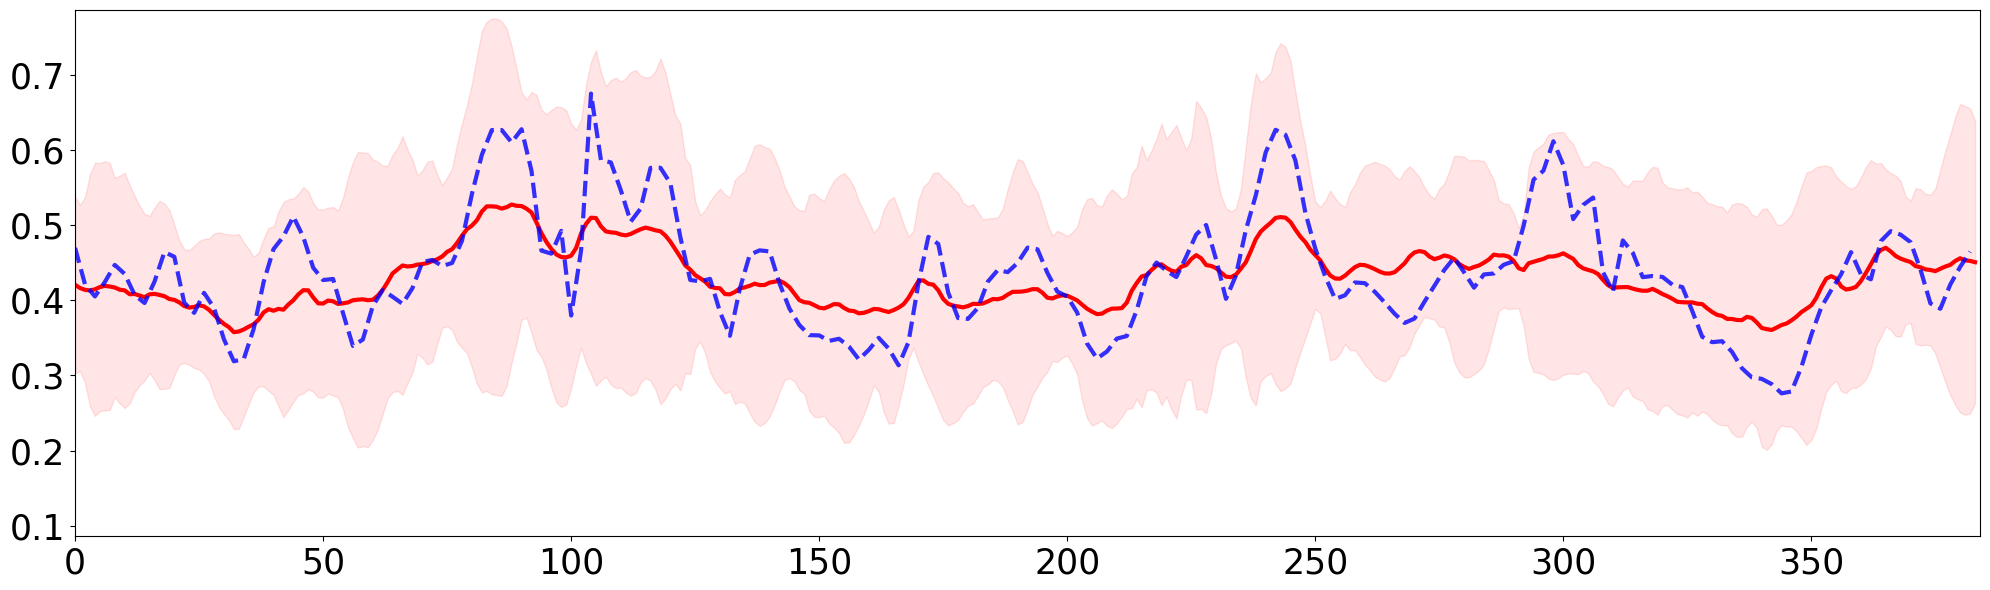

In [21]:
print(f"Train data shape: {train_probes[:1]}")
for probe in train_probes[:1]:
    print(f"probe: {probe}")
    range_ = 0.7
    scale = 3
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
    for _ in range(1):
        uncer_up_lim, uncer_down_lim = meand + scale*stdd, meand - scale*stdd
        axes.fill_between(np.arange(384), (uncer_up_lim)[:, probe], (uncer_down_lim)[:, probe], color='red', alpha=0.1)
        axes.plot(meand[:,  probe], color='red', linewidth=3)
        axes.plot(np.arange(384)[::2], train_data_Umag[::2, 0], "--",linewidth=3, alpha=0.8, color='blue')
        mean_gt_Umag = train_data_Umag[:, 0].mean()
        axes.set_ylim([mean_gt_Umag - range_/2 ,mean_gt_Umag + range_/2])
        axes.set_xlim([0,384])
    fig.tight_layout()
    plt.show()

dashed blue line represents the sensor measurements, red line is the mean of all generated samples at the sensor location. The shaded area is the uncertainty corresponding to $3 \sigma$.

single plot:

Plot saved to results/Reconstructed_vel_at_Probe57356.png


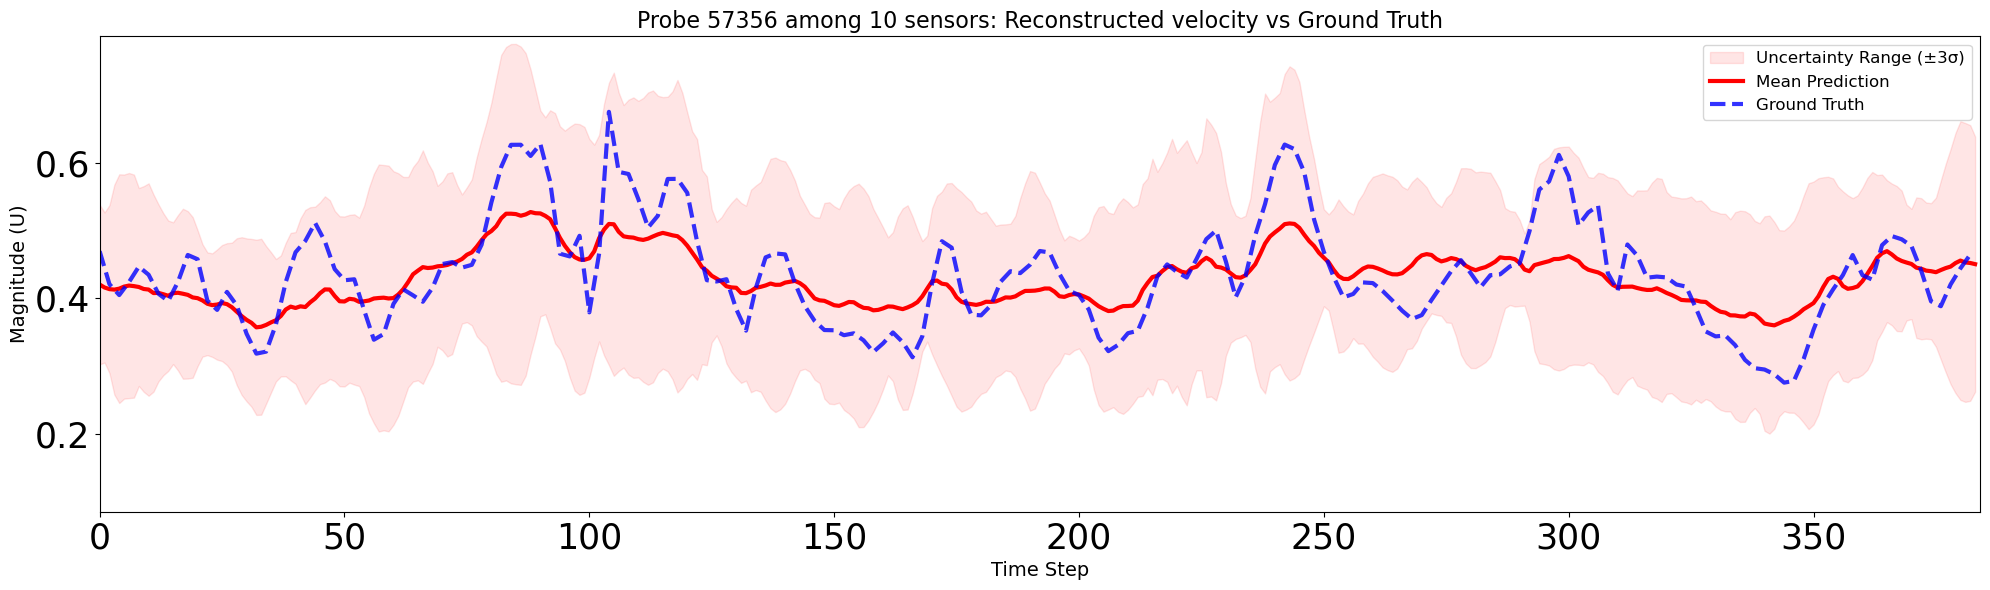

In [22]:
# Create results folder if it doesn't exist
import os
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

for probe in train_probes[:1]:
    range_ = 0.7
    scale = 3
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    
    for _ in range(1):
        # Upper and lower uncertainty limits
        uncer_up_lim, uncer_down_lim = meand + scale * stdd, meand - scale * stdd
        
        # Fill the uncertainty region
        axes.fill_between(
            np.arange(384), 
            (uncer_up_lim)[:, probe], 
            (uncer_down_lim)[:, probe], 
            color='red', 
            alpha=0.1, 
            label=f"Uncertainty Range (±{scale}σ)"
        )
        
        # Plot mean prediction
        axes.plot(
            meand[:, probe], 
            color='red', 
            linewidth=3, 
            label="Mean Prediction"
        )
        
        # Plot ground truth (sampled every 2 points for clarity)
        axes.plot(
            np.arange(384)[::2], 
            train_data_Umag[::2, 0], 
            "--", 
            linewidth=3, 
            alpha=0.8, 
            color='blue', 
            label="Ground Truth"
        )
        
        # Compute mean ground truth Umag
        mean_gt_Umag = train_data_Umag[:, 0].mean()
        
        # Set plot limits
        axes.set_ylim([mean_gt_Umag - range_ / 2, mean_gt_Umag + range_ / 2])
        axes.set_xlim([0, 384])
    
    # Add labels, title, and legend
    axes.set_xlabel("Time Step", fontsize=14)
    axes.set_ylabel("Magnitude (U)", fontsize=14)
    axes.set_title(f"Probe {probe} among {no_of_sensors} sensors: Reconstructed velocity vs Ground Truth", fontsize=16)
    axes.legend(fontsize=12)
    
    save_path = os.path.join(results_dir, f"Reconstructed_vel_at_Probe{probe}.png")
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    # Tight layout and show plot
    fig.tight_layout()
    plt.show()

multiple plots

Plot saved to results/Reconstructed_Velocity_Probes_0_to_8.png


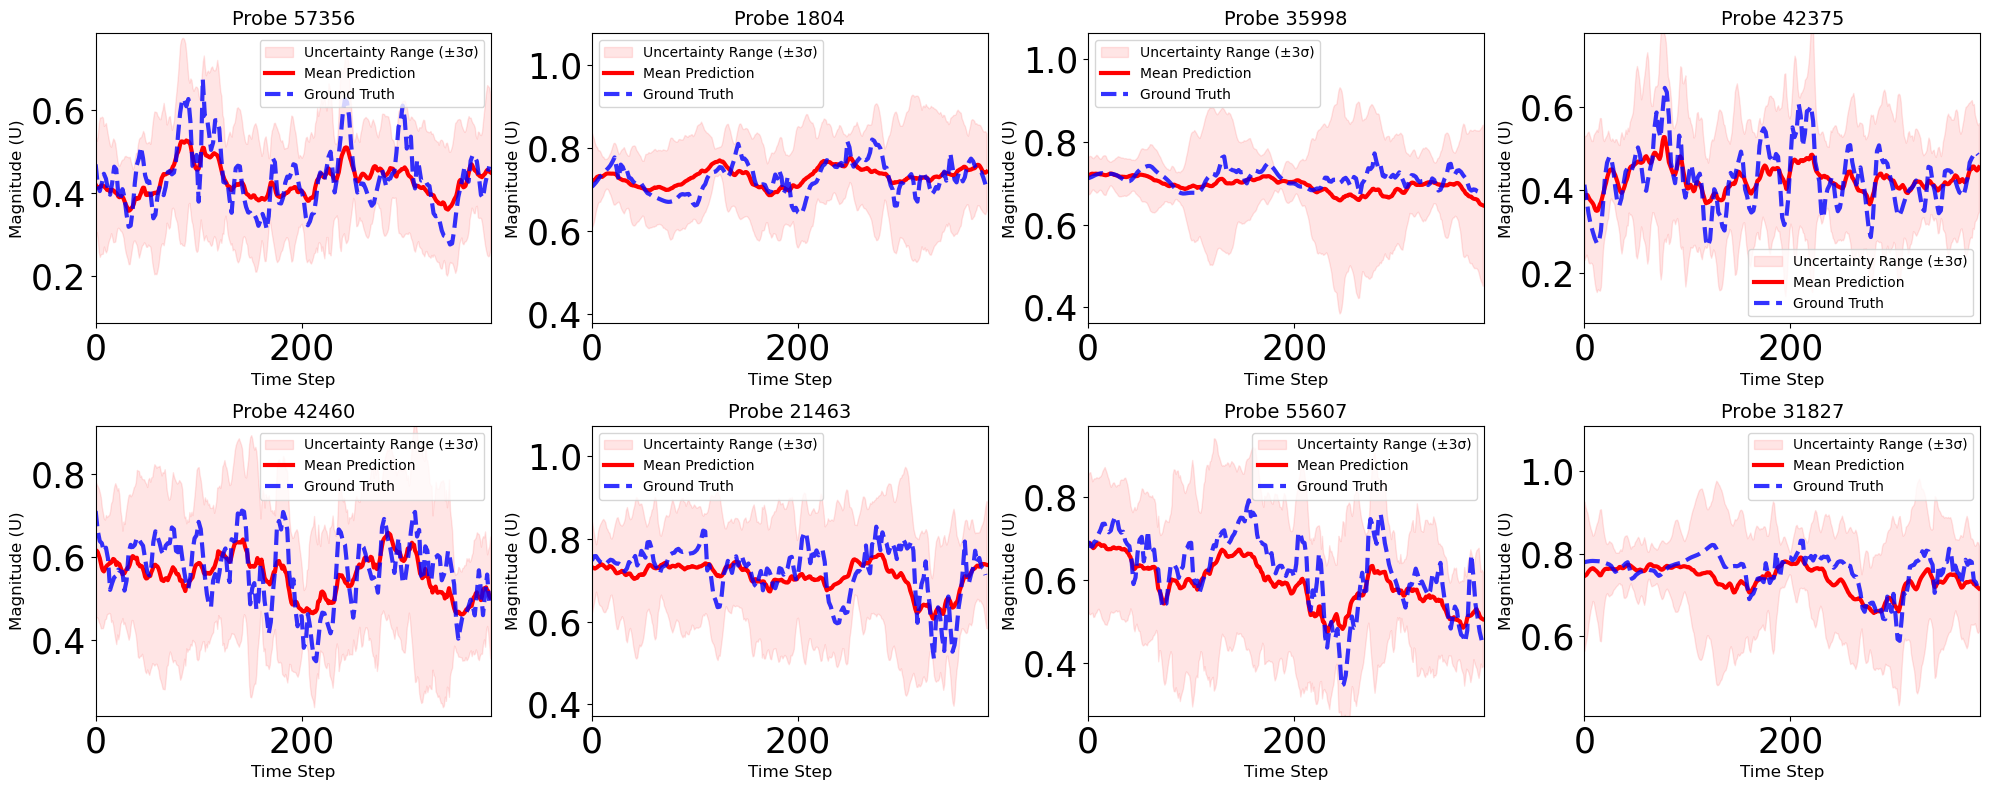

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create results directory if not exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Set visualization parameters
range_ = 0.7
scale = 3

# **User-defined range for probes to plot**
start_probe = 0  # Change this to select where to start (index-based)
end_probe = 8    # Change this to select where to end (not inclusive)
ncols = 4       # **Set the number of columns** in the subplot layout

# Ensure valid range
if start_probe < 0 or end_probe > len(train_probes) or start_probe >= end_probe:
    raise ValueError(f"Invalid range: choose between 0 and {len(train_probes)}")

# **Extract the selected probe indices**
selected_probes = train_probes[start_probe:end_probe]
num_probes = len(selected_probes)

# **Determine grid layout for side-by-side visualization**
nrows = (num_probes + ncols - 1) // ncols  # Compute required rows

# **Create figure with multiple subplots**
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows)) 

# Flatten axes for easy iteration if there are multiple rows/columns
axes = np.array(axes).flatten()

# Loop through each selected probe and plot on its assigned subplot
for idx, probe in enumerate(selected_probes):
    
    # Compute uncertainty bounds
    uncer_up_lim, uncer_down_lim = meand + scale * stdd, meand - scale * stdd

    # **Fill the uncertainty range in red**
    axes[idx].fill_between(
        np.arange(384), 
        (uncer_up_lim)[:, probe], 
        (uncer_down_lim)[:, probe], 
        color='red', 
        alpha=0.1, 
        label=f"Uncertainty Range (±{scale}σ)"
    )

    # **Plot mean predicted velocity**
    axes[idx].plot(
        meand[:, probe], 
        color='red', 
        linewidth=3, 
        label="Mean Prediction"
    )

    # **Plot ground truth for the corresponding sensor**
    axes[idx].plot(
        np.arange(384)[::2], 
        train_data_Umag[::2, start_probe + idx],  # Adjust index for correct mapping
        "--", 
        linewidth=3, 
        alpha=0.8, 
        color='blue', 
        label="Ground Truth"
    )

    # Compute mean ground truth Umag for y-limits
    mean_gt_Umag = train_data_Umag[:, start_probe + idx].mean()
    axes[idx].set_ylim([mean_gt_Umag - range_ / 2, mean_gt_Umag + range_ / 2])
    axes[idx].set_xlim([0, 384])

    # **Add labels, title, and legend**
    axes[idx].set_xlabel("Time Step", fontsize=12)
    axes[idx].set_ylabel("Magnitude (U)", fontsize=12)
    axes[idx].set_title(f"Probe {probe}", fontsize=14)
    axes[idx].legend(fontsize=10)

# **Remove unused subplots if fewer probes are selected**
for idx in range(num_probes, len(axes)):
    fig.delaxes(axes[idx])  

# **Tight layout and save the full figure**
fig.tight_layout()
save_path = os.path.join(results_dir, f"Reconstructed_Velocity_Probes_{start_probe}_to_{end_probe}.png")
plt.savefig(save_path, dpi=300)
print(f"Plot saved to {save_path}")

# **Show the figure**
plt.show()

/var/folders/bc/tkxqx5c57fgcftsfpjb5zk8c0000gn/T/ipykernel_1243/3902769378.py:89: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  axes[idx].set_yticks(np.arange(mean_gt_Umag - range_ / 2, mean_gt_Umag + range_ / 2 + y_interval, y_interval))  # Custom y-axis tick interval


High-resolution plot saved to results/HighRes_Velocity_Probes_0_to_8.png


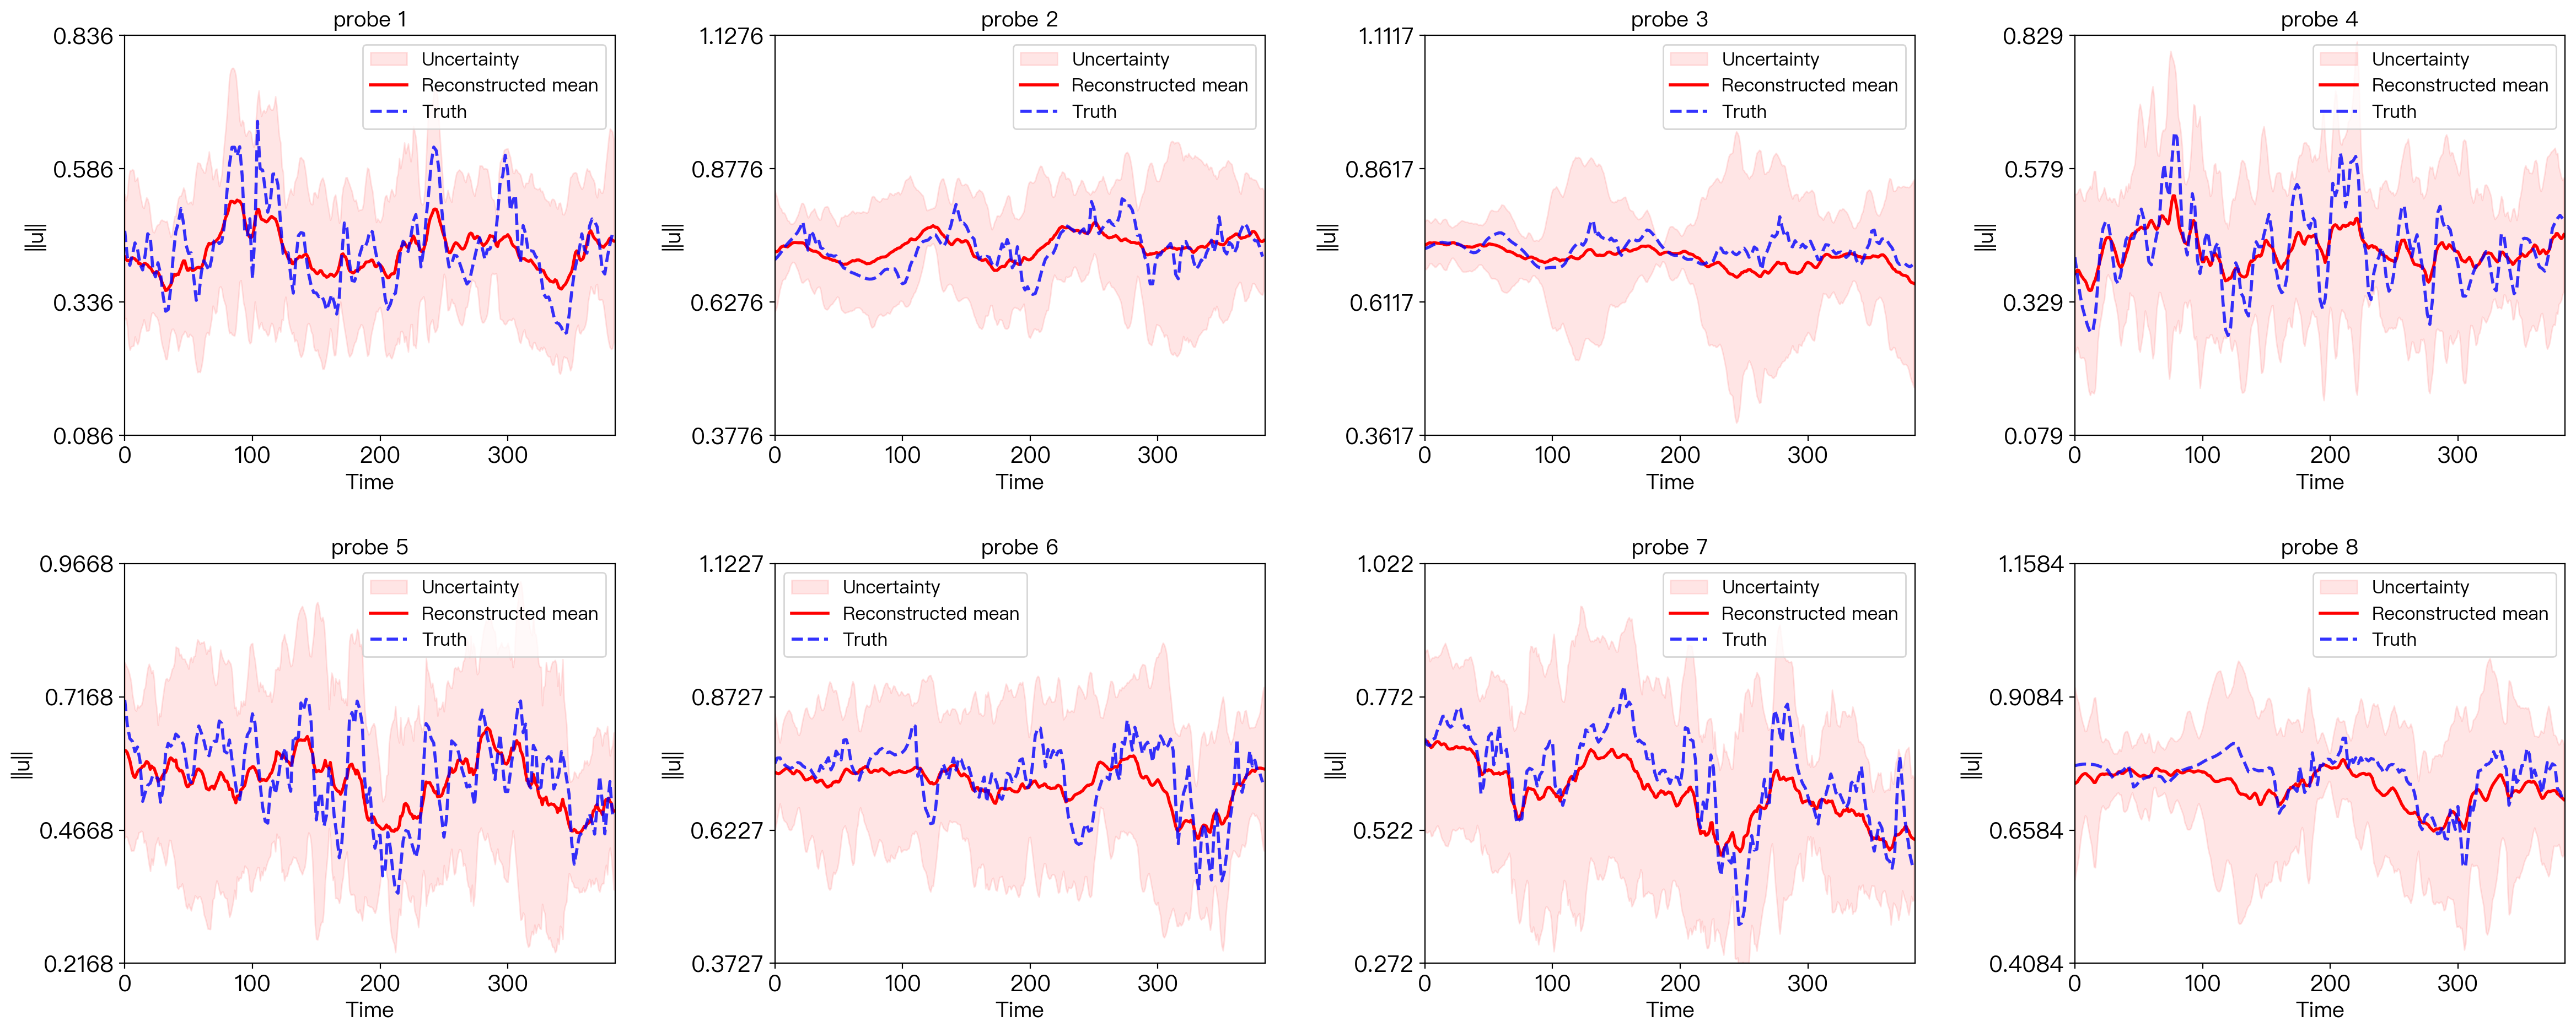

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Configure the font and enable Chinese character support
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["PingFang HK"],  # Adjust as needed
    "axes.unicode_minus": False  # Ensure minus signs are rendered correctly
})

# Create results directory if not exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Set visualization parameters
range_ = 0.7
scale = 3

# **User-defined range for probes to plot**
start_probe = 0  # Change this to select where to start (index-based)
end_probe = 8    # Change this to select where to end (not inclusive)
ncols = 4        # **Set the number of columns** in the subplot layout

# **User-defined tick intervals**
x_interval = 100  # Adjust for better x-axis resolution
y_interval = 0.25  # Adjust for better y-axis resolution

# Ensure valid range
if start_probe < 0 or end_probe > len(train_probes) or start_probe >= end_probe:
    raise ValueError(f"Invalid range: choose between 0 and {len(train_probes)}")

# **Extract the selected probe indices**
selected_probes = train_probes[start_probe:end_probe]
num_probes = len(selected_probes)

# **Determine grid layout for side-by-side visualization**
nrows = (num_probes + ncols - 1) // ncols  # Compute required rows

# **Create figure with high resolution and larger subplots**
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), dpi=200)  

# Flatten axes for easy iteration if there are multiple rows/columns
axes = np.array(axes).flatten()

# Loop through each selected probe and plot on its assigned subplot
for idx, probe in enumerate(selected_probes):
    
    # Compute uncertainty bounds
    uncer_up_lim, uncer_down_lim = meand + scale * stdd, meand - scale * stdd

    # **Fill the uncertainty range in red**
    axes[idx].fill_between(
        np.arange(384), 
        (uncer_up_lim)[:, probe], 
        (uncer_down_lim)[:, probe], 
        color='red', 
        alpha=0.1, 
        #label=f"Uncertainty (±{scale}σ)"
        label=f"Uncertainty"
    )

    # **Plot mean predicted velocity**
    axes[idx].plot(
        meand[:, probe], 
        color='red', 
        linewidth=2, 
        label="Reconstructed mean"
    )

    # **Plot ground truth for the corresponding sensor**
    axes[idx].plot(
        np.arange(384)[::2], 
        train_data_Umag[::2, start_probe + idx],  # Adjust index for correct mapping
        "--", 
        linewidth=2, 
        alpha=0.8, 
        color='blue', 
        label="Truth"
    )

    # Compute mean ground truth Umag for y-limits
    mean_gt_Umag = train_data_Umag[:, start_probe + idx].mean()
    axes[idx].set_ylim([mean_gt_Umag - range_ / 2, mean_gt_Umag + range_ / 2])
    axes[idx].set_xlim([0, 384])

    # **Set user-defined tick intervals**
    axes[idx].set_xticks(np.arange(0, 385, x_interval))  # Custom x-axis tick interval
    axes[idx].set_yticks(np.arange(mean_gt_Umag - range_ / 2, mean_gt_Umag + range_ / 2 + y_interval, y_interval))  # Custom y-axis tick interval

    tick_fontsize = 15  # **Set smaller tick font size**
    axes[idx].tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # **Add labels, title, and legend**
    axes[idx].set_xlabel("Time", fontsize=14)
    axes[idx].set_ylabel("||u||", fontsize=14)
    #axes[idx].set_title(f"测点 {probe}", fontsize=16)
    axes[idx].set_title(f"probe {idx + 1}", fontsize=14)  # **Numbering starts from 1**
    axes[idx].legend(fontsize=12)

# **Remove unused subplots if fewer probes are selected**
for idx in range(num_probes, len(axes)):
    fig.delaxes(axes[idx])  

# **Tight layout with increased padding for clarity**
fig.tight_layout(pad=3.0)

# **Save high-resolution figure**
save_path = os.path.join(results_dir, f"HighRes_Velocity_Probes_{start_probe}_to_{end_probe}.png")
plt.savefig(save_path, dpi=400, bbox_inches='tight')  # Increased DPI for high resolution
print(f"High-resolution plot saved to {save_path}")

# **Show the figure**
plt.show()